
#Predicting Employee Promotions
> Add blockquote



In [214]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from imblearn.over_sampling import SMOTE
from sklearn.metrics import accuracy_score,precision_score, f1_score,recall_score, confusion_matrix, classification_report

# Data wrangling

In [215]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [216]:
#read the data into a dataframe
df = pd.read_csv('/content/drive/MyDrive/promo/aug_train.csv.zip', index_col ='enrollee_id')
df.head()


,city,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours,target
enrollee_id,,,,,,,,,,,,,
8949,city_103,0.920,Male,Has relevent experience,no_enrollment,Graduate,STEM,>20,NaN,NaN,1,36,1.0
29725,city_40,0.776,Male,No relevent experience,no_enrollment,Graduate,STEM,15,50-99,Pvt Ltd,>4,47,0.0
11561,city_21,0.624,NaN,No relevent experience,Full time course,Graduate,STEM,5,NaN,NaN,never,83,0.0
33241,city_115,0.789,NaN,No relevent experience,NaN,Graduate,Business Degree,<1,NaN,Pvt Ltd,never,52,1.0
666,city_162,0.767,Male,Has relevent experience,no_enrollment,Masters,STEM,>20,50-99,Funded Startup,4,8,0.0


In [217]:
#observe the columns
df.columns

Index(['city', 'city_development_index', 'gender', 'relevent_experience',
       'enrolled_university', 'education_level', 'major_discipline',
       'experience', 'company_size', 'company_type', 'last_new_job',
       'training_hours', 'target'],
      dtype='object')


Features

● enrollee_id : Unique ID for candidate.

● city: City code.

● city_ development _index : Development index of the city (scaled).

● gender: Gender of candidate

● relevent_experience: Relevant experience of candidate

● enrolled_university: Type of University course enrolled if any

● education_level: Education level of candidate

● major_discipline :Education major discipline of candidate

● experience: Candidate total experience in years

● company_size: No of employees in current employer's company

● company_type : Type of current employer

● last_new_job: Difference in years between previous job and current job

● training_hours: training hours completed

● target: 0 – Not looking for promotion, 1 – Looking for a promotion

In [218]:
#observe no. of rows and columns
df.shape

(19158, 13)

In [219]:
#get more info about data types and non-null values
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 19158 entries, 8949 to 23834
Data columns (total 13 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   city                    19158 non-null  object 
 1   city_development_index  19158 non-null  float64
 2   gender                  14650 non-null  object 
 3   relevent_experience     19158 non-null  object 
 4   enrolled_university     18772 non-null  object 
 5   education_level         18698 non-null  object 
 6   major_discipline        16345 non-null  object 
 7   experience              19093 non-null  object 
 8   company_size            13220 non-null  object 
 9   company_type            13018 non-null  object 
 10  last_new_job            18735 non-null  object 
 11  training_hours          19158 non-null  int64  
 12  target                  19158 non-null  float64
dtypes: float64(2), int64(1), object(10)
memory usage: 2.0+ MB


In [220]:
# get percentages of null values
df.isnull().sum()/len(df)*100

,0
city,0.000000
city_development_index,0.000000
gender,23.530640
relevent_experience,0.000000
enrolled_university,2.014824
education_level,2.401086
major_discipline,14.683161
experience,0.339284
company_size,30.994885
company_type,32.049274


##handle the missing values

In [221]:


#drop rows of columns with less than 10% null values
df.dropna(subset =['enrolled_university','education_level','experience','last_new_job'], inplace = True)


#fill columns with more than 10% null values with there mode

df['gender'].fillna(df['gender'].mode()[0], inplace = True)
df['major_discipline'].fillna(df['major_discipline'].mode()[0], inplace = True)
df['company_size'].fillna(df['company_size'].mode()[0], inplace = True)
df['company_type'].fillna(df['company_type'].mode()[0], inplace = True)



In [222]:
#confirm if they are all filled
df.isnull().sum()

,0
city,0
city_development_index,0
gender,0
relevent_experience,0
enrolled_university,0
education_level,0
major_discipline,0
experience,0
company_size,0
company_type,0


##handle duplicates

In [223]:
#identify duplicates
df.duplicated().sum()



85

In [224]:
#drop them
df.drop_duplicates(inplace = True)

#Exploratory Data Analysis

##categorical analysis

visualize the dataset to understand key features influencing promotion decisions

In [225]:
#observe value counts for all columns as per their uniques
for col in df.columns:
    print(col,'number of unique values is :',df[col].nunique())
    print('value counts is :',df[col].value_counts())
    print('---------------------------')

city number of unique values is : 123
value counts is : city
city_103    4136
city_21     2442
city_16     1461
city_114    1254
city_160     813
            ... 
city_111       3
city_129       2
city_8         2
city_140       1
city_171       1
Name: count, Length: 123, dtype: int64
---------------------------
city_development_index number of unique values is : 93
value counts is : city_development_index
0.920    4949
0.624    2442
0.910    1461
0.926    1254
0.698     593
         ... 
0.693       3
0.649       3
0.781       3
0.625       2
0.664       1
Name: count, Length: 93, dtype: int64
---------------------------
gender number of unique values is : 3
value counts is : gender
Male      16551
Female     1205
Other       173
Name: count, dtype: int64
---------------------------
relevent_experience number of unique values is : 2
value counts is : relevent_experience
Has relevent experience    13117
No relevent experience      4812
Name: count, dtype: int64
-----------------------

In [226]:
#observe no. of unique values
df.nunique().sort_values(ascending = False)

,0
training_hours,241
city,123
city_development_index,93
experience,22
company_size,8
major_discipline,6
company_type,6
last_new_job,6
education_level,5
gender,3


##columns visualizations

Target visulazition

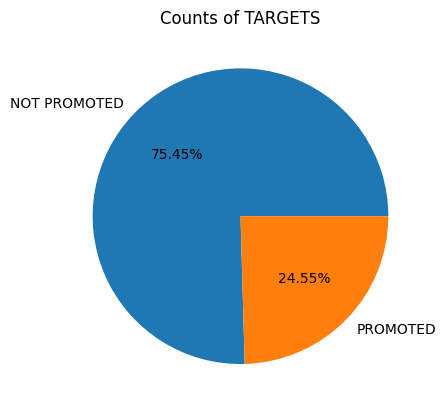

In [227]:
#distribution of the target column
target_vals = df['target'].value_counts()
outcome_labels = ['NOT PROMOTED','PROMOTED']
plt.pie(target_vals,labels=outcome_labels, autopct='%.2f%%')
plt.title('Counts of TARGETS')
plt.show()

City visualization

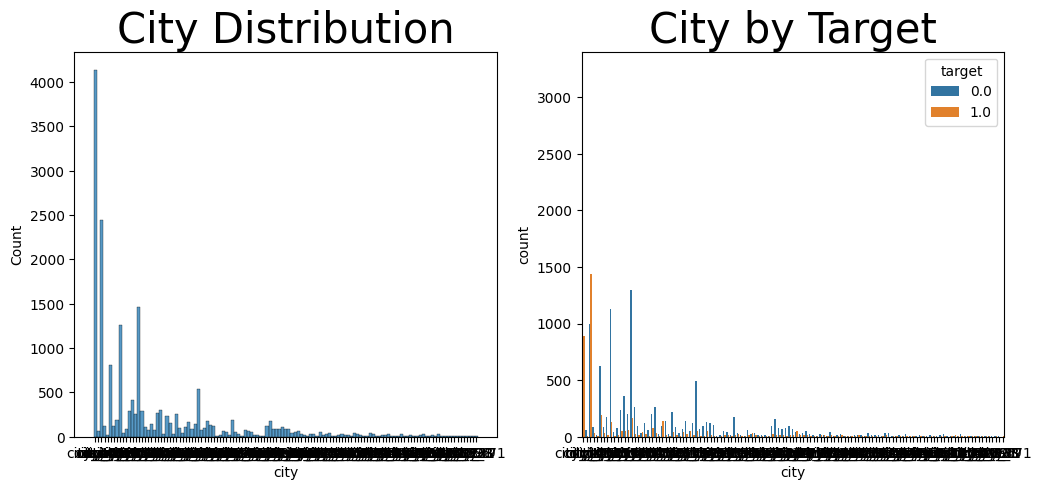

In [228]:
#plot distribution
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.title('City Distribution',fontsize = 30)
sns.histplot(df['city'],bins=20)

#plot city by target
plt.subplot(1,2,2)
sns.countplot(x = 'city',data = df, hue = 'target')
plt.title('City by Target', fontsize = 30);

city_development_index

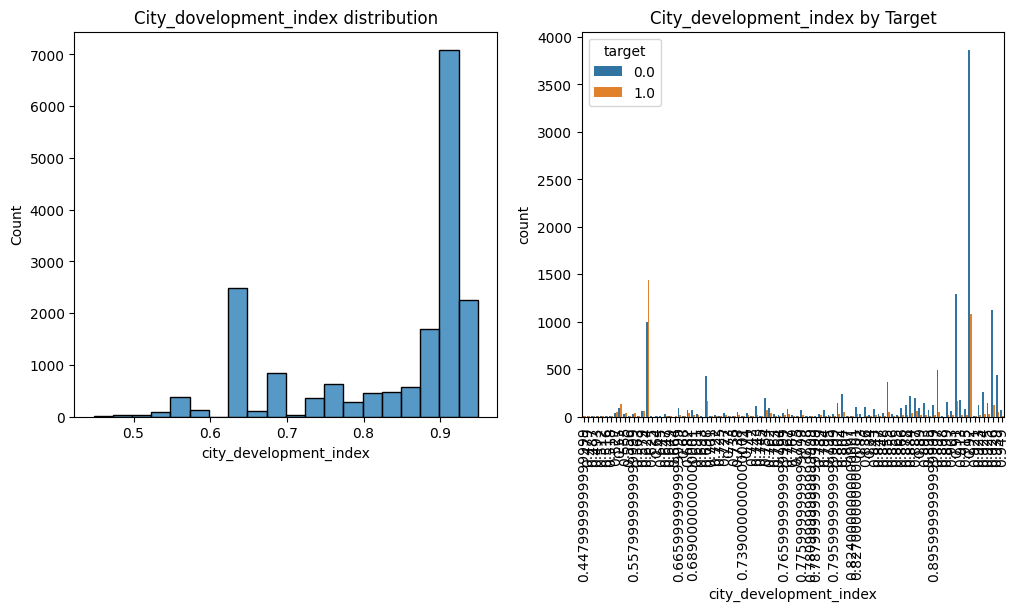

In [229]:
#plot distribution
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.title('City_dovelopment_index distribution')
sns.histplot(df['city_development_index'],bins=20)

#plot city by target
plt.subplot(1,2,2)
plt.title('City_development_index by Target')
sns.countplot(x = 'city_development_index',data = df, hue = 'target')
plt.xticks(rotation=90);

  gender  visualization

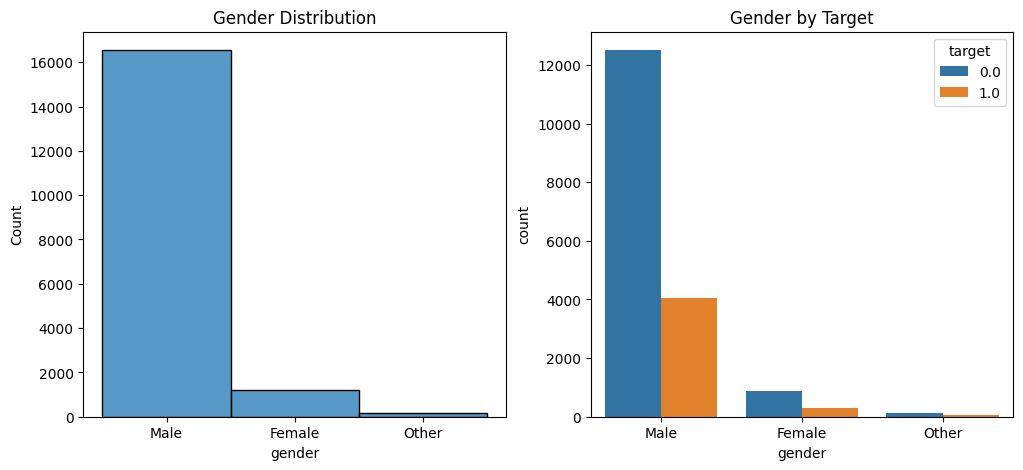

In [230]:
#plot distribution
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.title('Gender Distribution')
sns.histplot(df['gender'],bins=20)


#plot city by target
plt.subplot(1,2,2)
plt.title('Gender by Target')
sns.countplot(x = 'gender',data = df, hue = 'target')
plt.show()

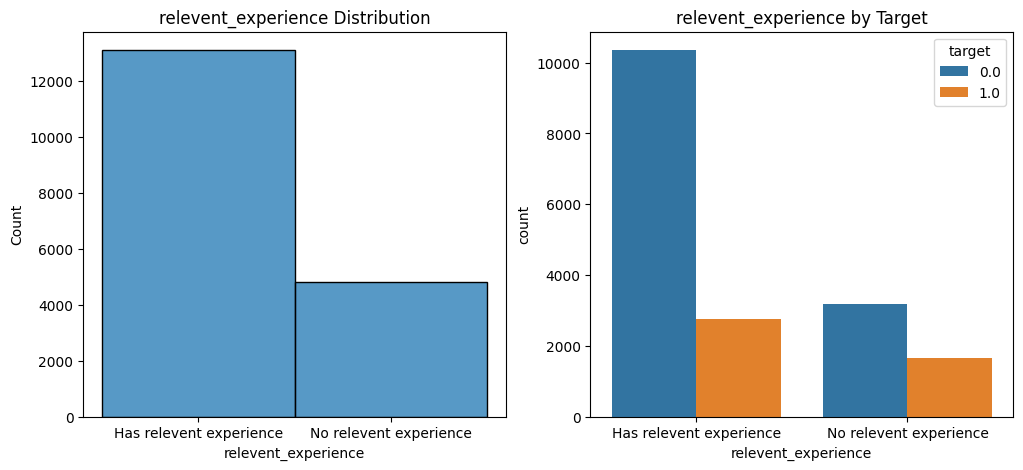

In [231]:
#plot distribution
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.title('relevent_experience Distribution')
sns.histplot(df['relevent_experience'],bins=20)

#plot city by target
plt.subplot(1,2,2)
plt.title('relevent_experience by Target')
sns.countplot(x = 'relevent_experience',data = df, hue = 'target')
plt.show()

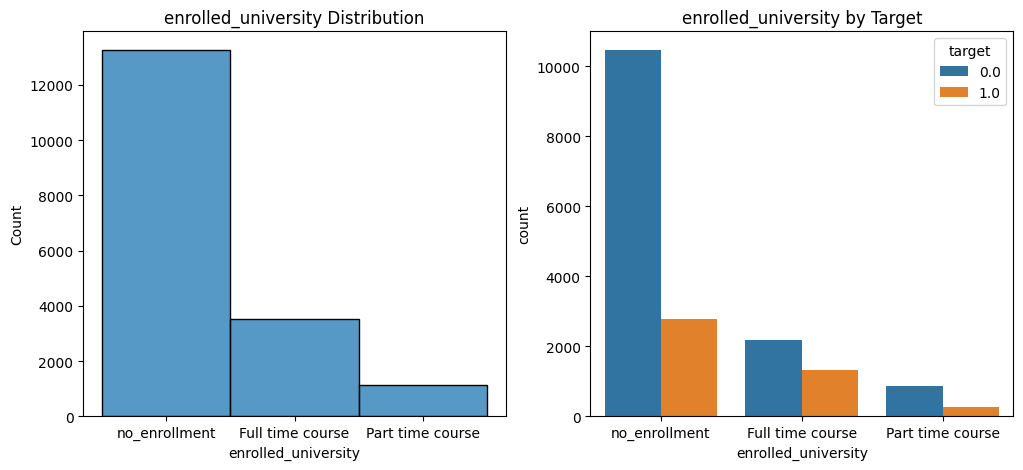

In [232]:
#plot distribution
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.title('enrolled_university Distribution')
sns.histplot(df['enrolled_university'],bins=20)

#plot city by target
plt.subplot(1,2,2)
plt.title('enrolled_university by Target')
sns.countplot(x = 'enrolled_university',data = df, hue = 'target')
plt.show()

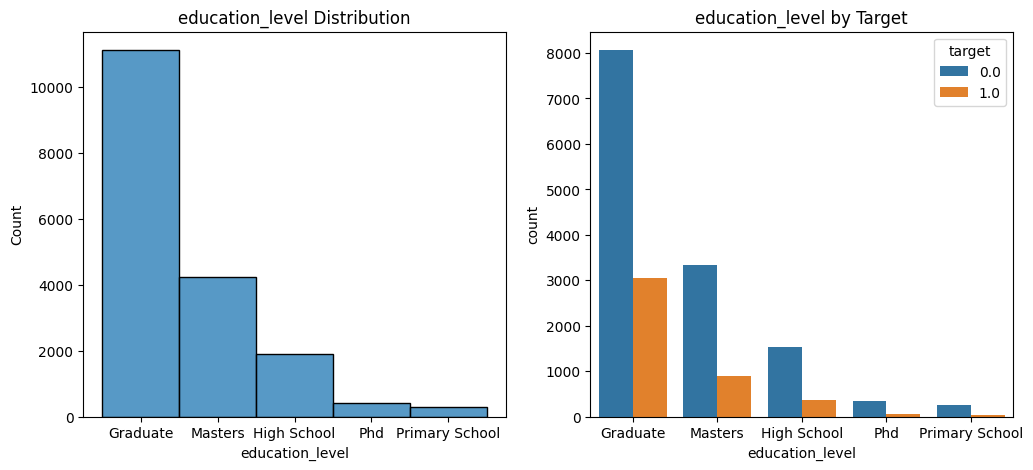

In [233]:
#plot distribution
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.title('education_level Distribution')
sns.histplot(df['education_level'],bins=20)

#plot city by target
plt.subplot(1,2,2)
plt.title('education_level by Target')
sns.countplot(x = 'education_level',data = df, hue = 'target')
plt.show()

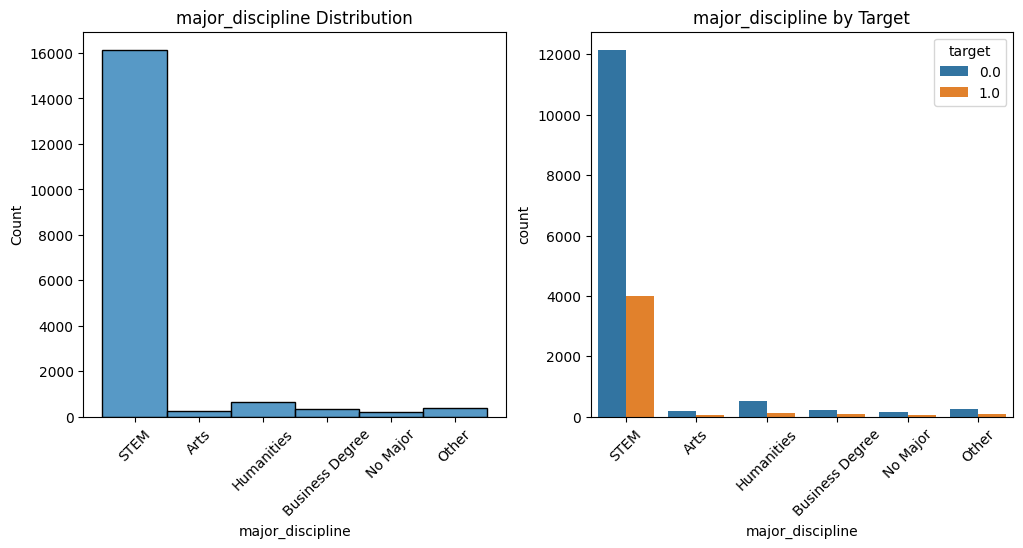

In [234]:
#plot distribution
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.title('major_discipline Distribution')
sns.histplot(df['major_discipline'])
plt.xticks(rotation = 45)

#plot city by target
plt.subplot(1,2,2)
plt.title('major_discipline by Target')
sns.countplot(x = 'major_discipline',data = df, hue = 'target')
plt.xticks(rotation = 45)
plt.show()

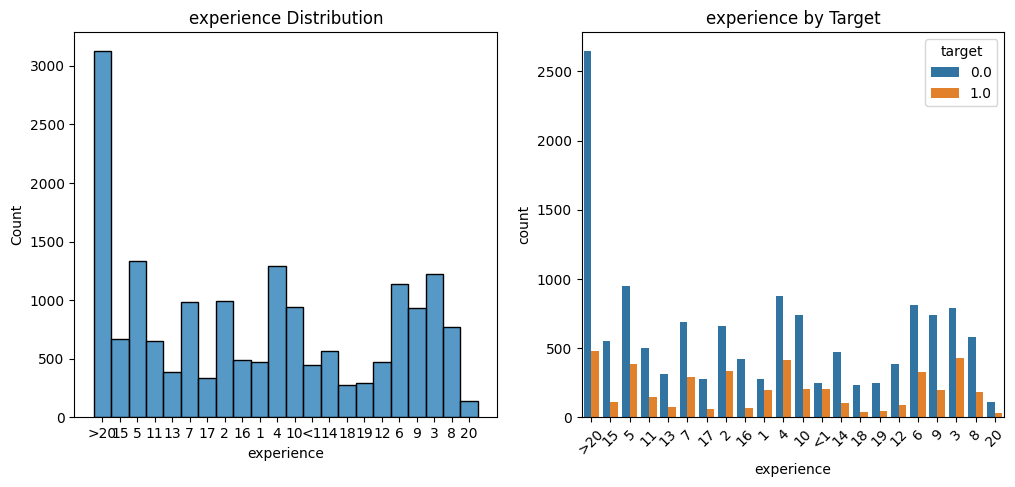

In [235]:
#plot distribution
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.title('experience Distribution')
sns.histplot(df['experience'],bins=20)

#plot city by target
plt.subplot(1,2,2)
plt.title('experience by Target')
sns.countplot(x = 'experience',data = df, hue = 'target')
plt.xticks(rotation = 45)
plt.show()

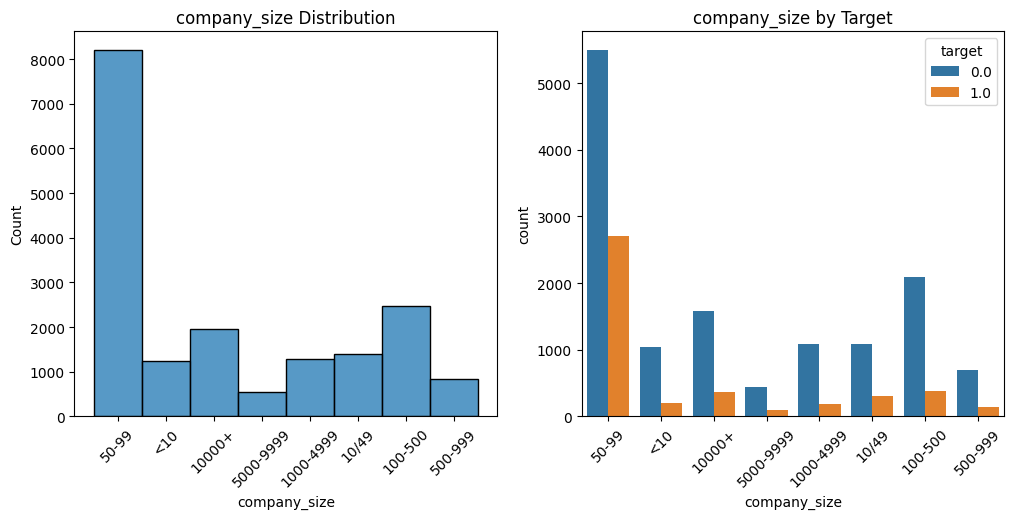

In [236]:
#plot distribution
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.title('company_size Distribution')
sns.histplot(df['company_size'])
plt.xticks(rotation = 45)

#plot city by target
plt.subplot(1,2,2)
plt.title('company_size by Target')
sns.countplot(x = 'company_size',data = df, hue = 'target')
plt.xticks(rotation = 45)
plt.show()

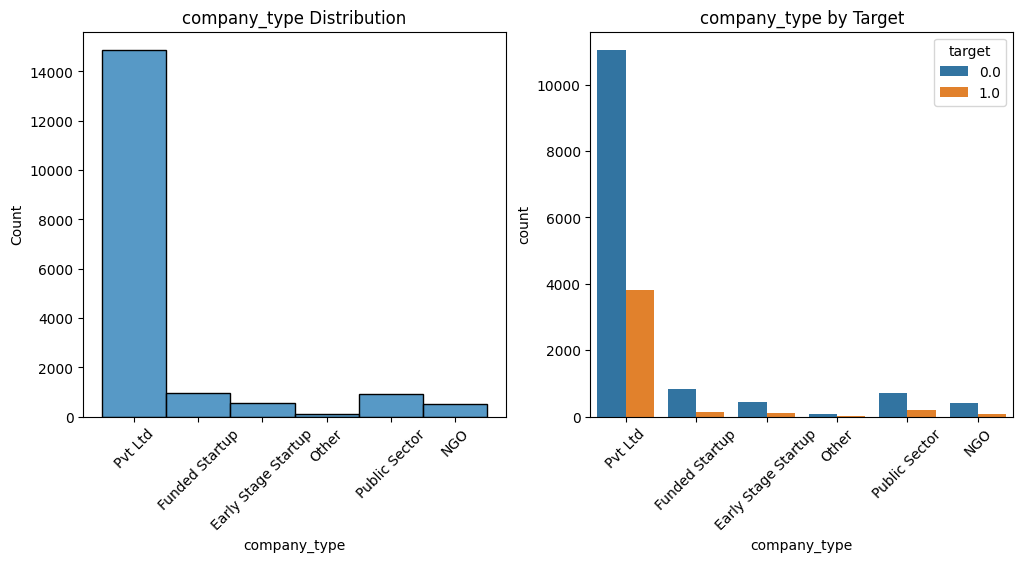

In [237]:
#plot distribution
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.title('company_type Distribution')
sns.histplot(df['company_type'],bins=20)
plt.xticks(rotation = 45)

#plot city by target
plt.subplot(1,2,2)
plt.title('company_type by Target')
sns.countplot(x = 'company_type',data = df, hue = 'target')
plt.xticks(rotation = 45)
plt.show()

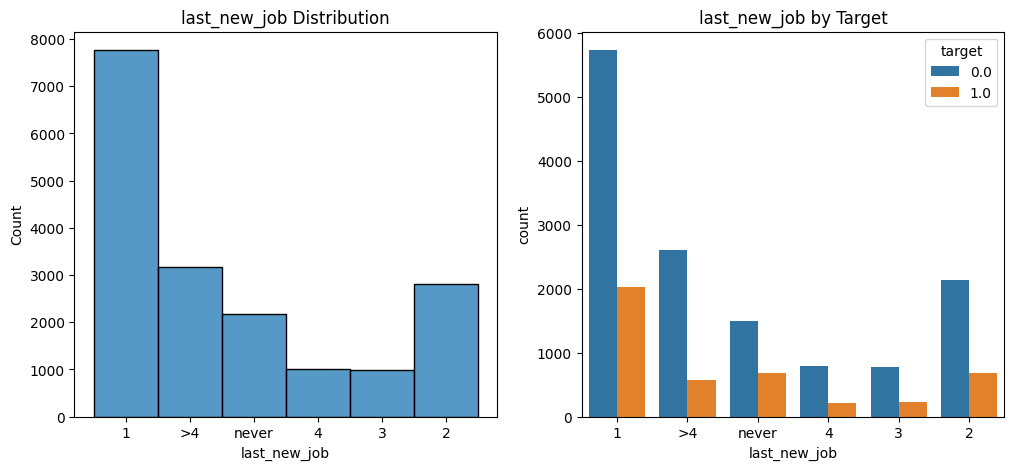

In [238]:
#plot distribution
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.title('last_new_job Distribution')
sns.histplot(df['last_new_job'],bins=20)

#plot city by target
plt.subplot(1,2,2)
plt.title('last_new_job by Target')
sns.countplot(x = 'last_new_job',data = df, hue = 'target')
plt.show()

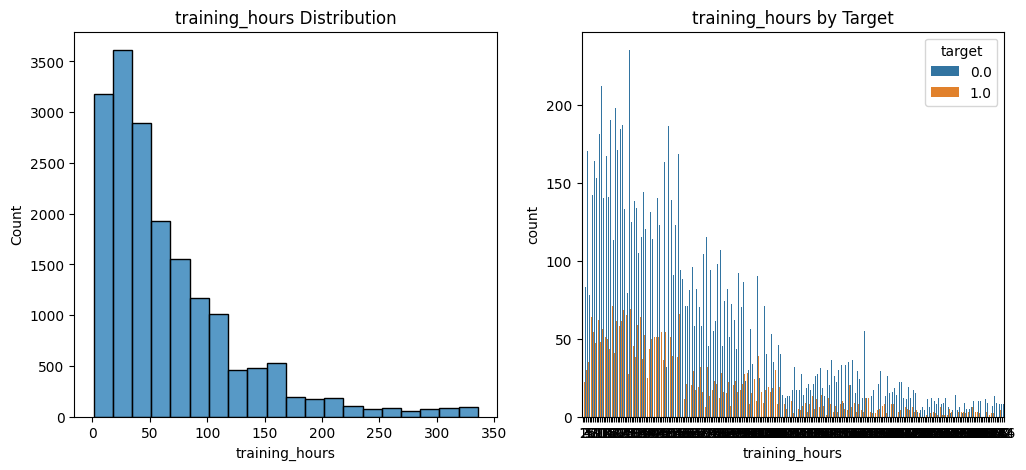

In [239]:
#plot distribution
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.title('training_hours Distribution')
sns.histplot(df['training_hours'],bins=20)

#plot city by target
plt.subplot(1,2,2)
plt.title('training_hours by Target')
sns.countplot(x = 'training_hours',data = df, hue = 'target')
plt.show()

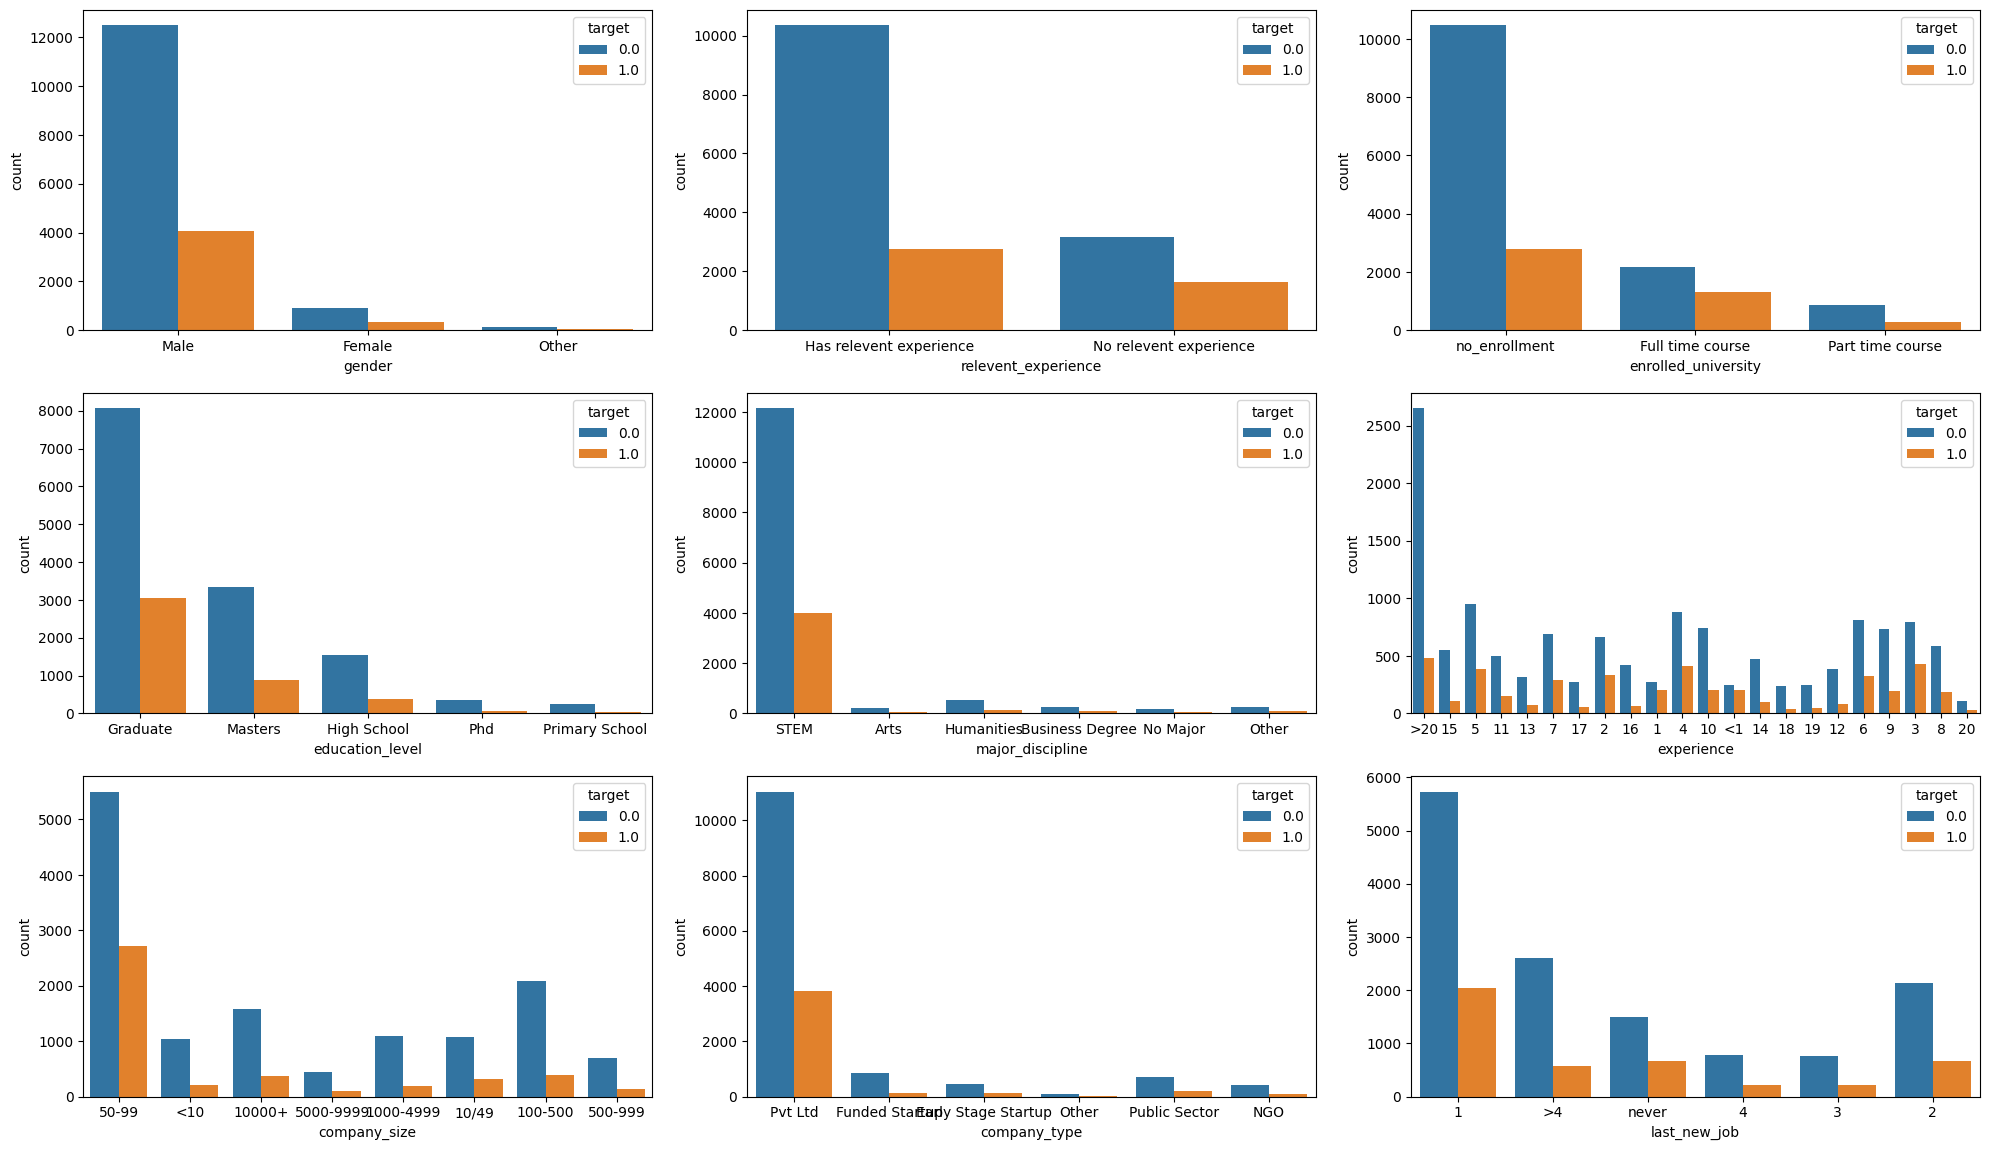

In [240]:
cat_feat=df.drop(['city','city_development_index','target','training_hours'],axis=1).columns

plt.figure(figsize=(20,15))
for i in range(len(cat_feat)):
    plt.subplot(4,3,i+1)
    sns.countplot(x=cat_feat[i],data=df,hue='target')
plt.tight_layout()
plt.show()

#Encode the categorical data

In [241]:
#encode using label encoder
lr = LabelEncoder()
columns = ['city','gender','major_discipline','company_type']
for col in columns:
  df[col] = lr.fit_transform(df[col])



#encode ordinal data with ordinal encoding
df['relevent_experience'] = df['relevent_experience'].map({'Has relevent experience': 1,'No relevent experience': 0})
df['enrolled_university'] = df['enrolled_university'].map({'Full time course': 0,'Part time course': 1,'no_enrollment': 3})
df['education_level'] = df['education_level'].map({'Graduate': 3,'Masters': 4,'High School': 2,'Phd': 5,'Primary School': 1})
df['company_size'] = df['company_size'].map({'50-99':2, '<10':0, '10000+':7, '5000-9999':6, '1000-4999':5, '10/49':1, '100-500':3,'500-999':4})

df['experience'] = df['experience'].replace({'>20':21, '<1':0}).astype(int)
df['last_new_job'] = df['last_new_job'].replace({'>4':5,'never':0}).astype(int)


In [242]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 17929 entries, 8949 to 23834
Data columns (total 13 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   city                    17929 non-null  int64  
 1   city_development_index  17929 non-null  float64
 2   gender                  17929 non-null  int64  
 3   relevent_experience     17929 non-null  int64  
 4   enrolled_university     17929 non-null  int64  
 5   education_level         17929 non-null  int64  
 6   major_discipline        17929 non-null  int64  
 7   experience              17929 non-null  int64  
 8   company_size            17929 non-null  int64  
 9   company_type            17929 non-null  int64  
 10  last_new_job            17929 non-null  int64  
 11  training_hours          17929 non-null  int64  
 12  target                  17929 non-null  float64
dtypes: float64(2), int64(11)
memory usage: 1.9 MB


##columns visualizations after encoding

distribution of features by target

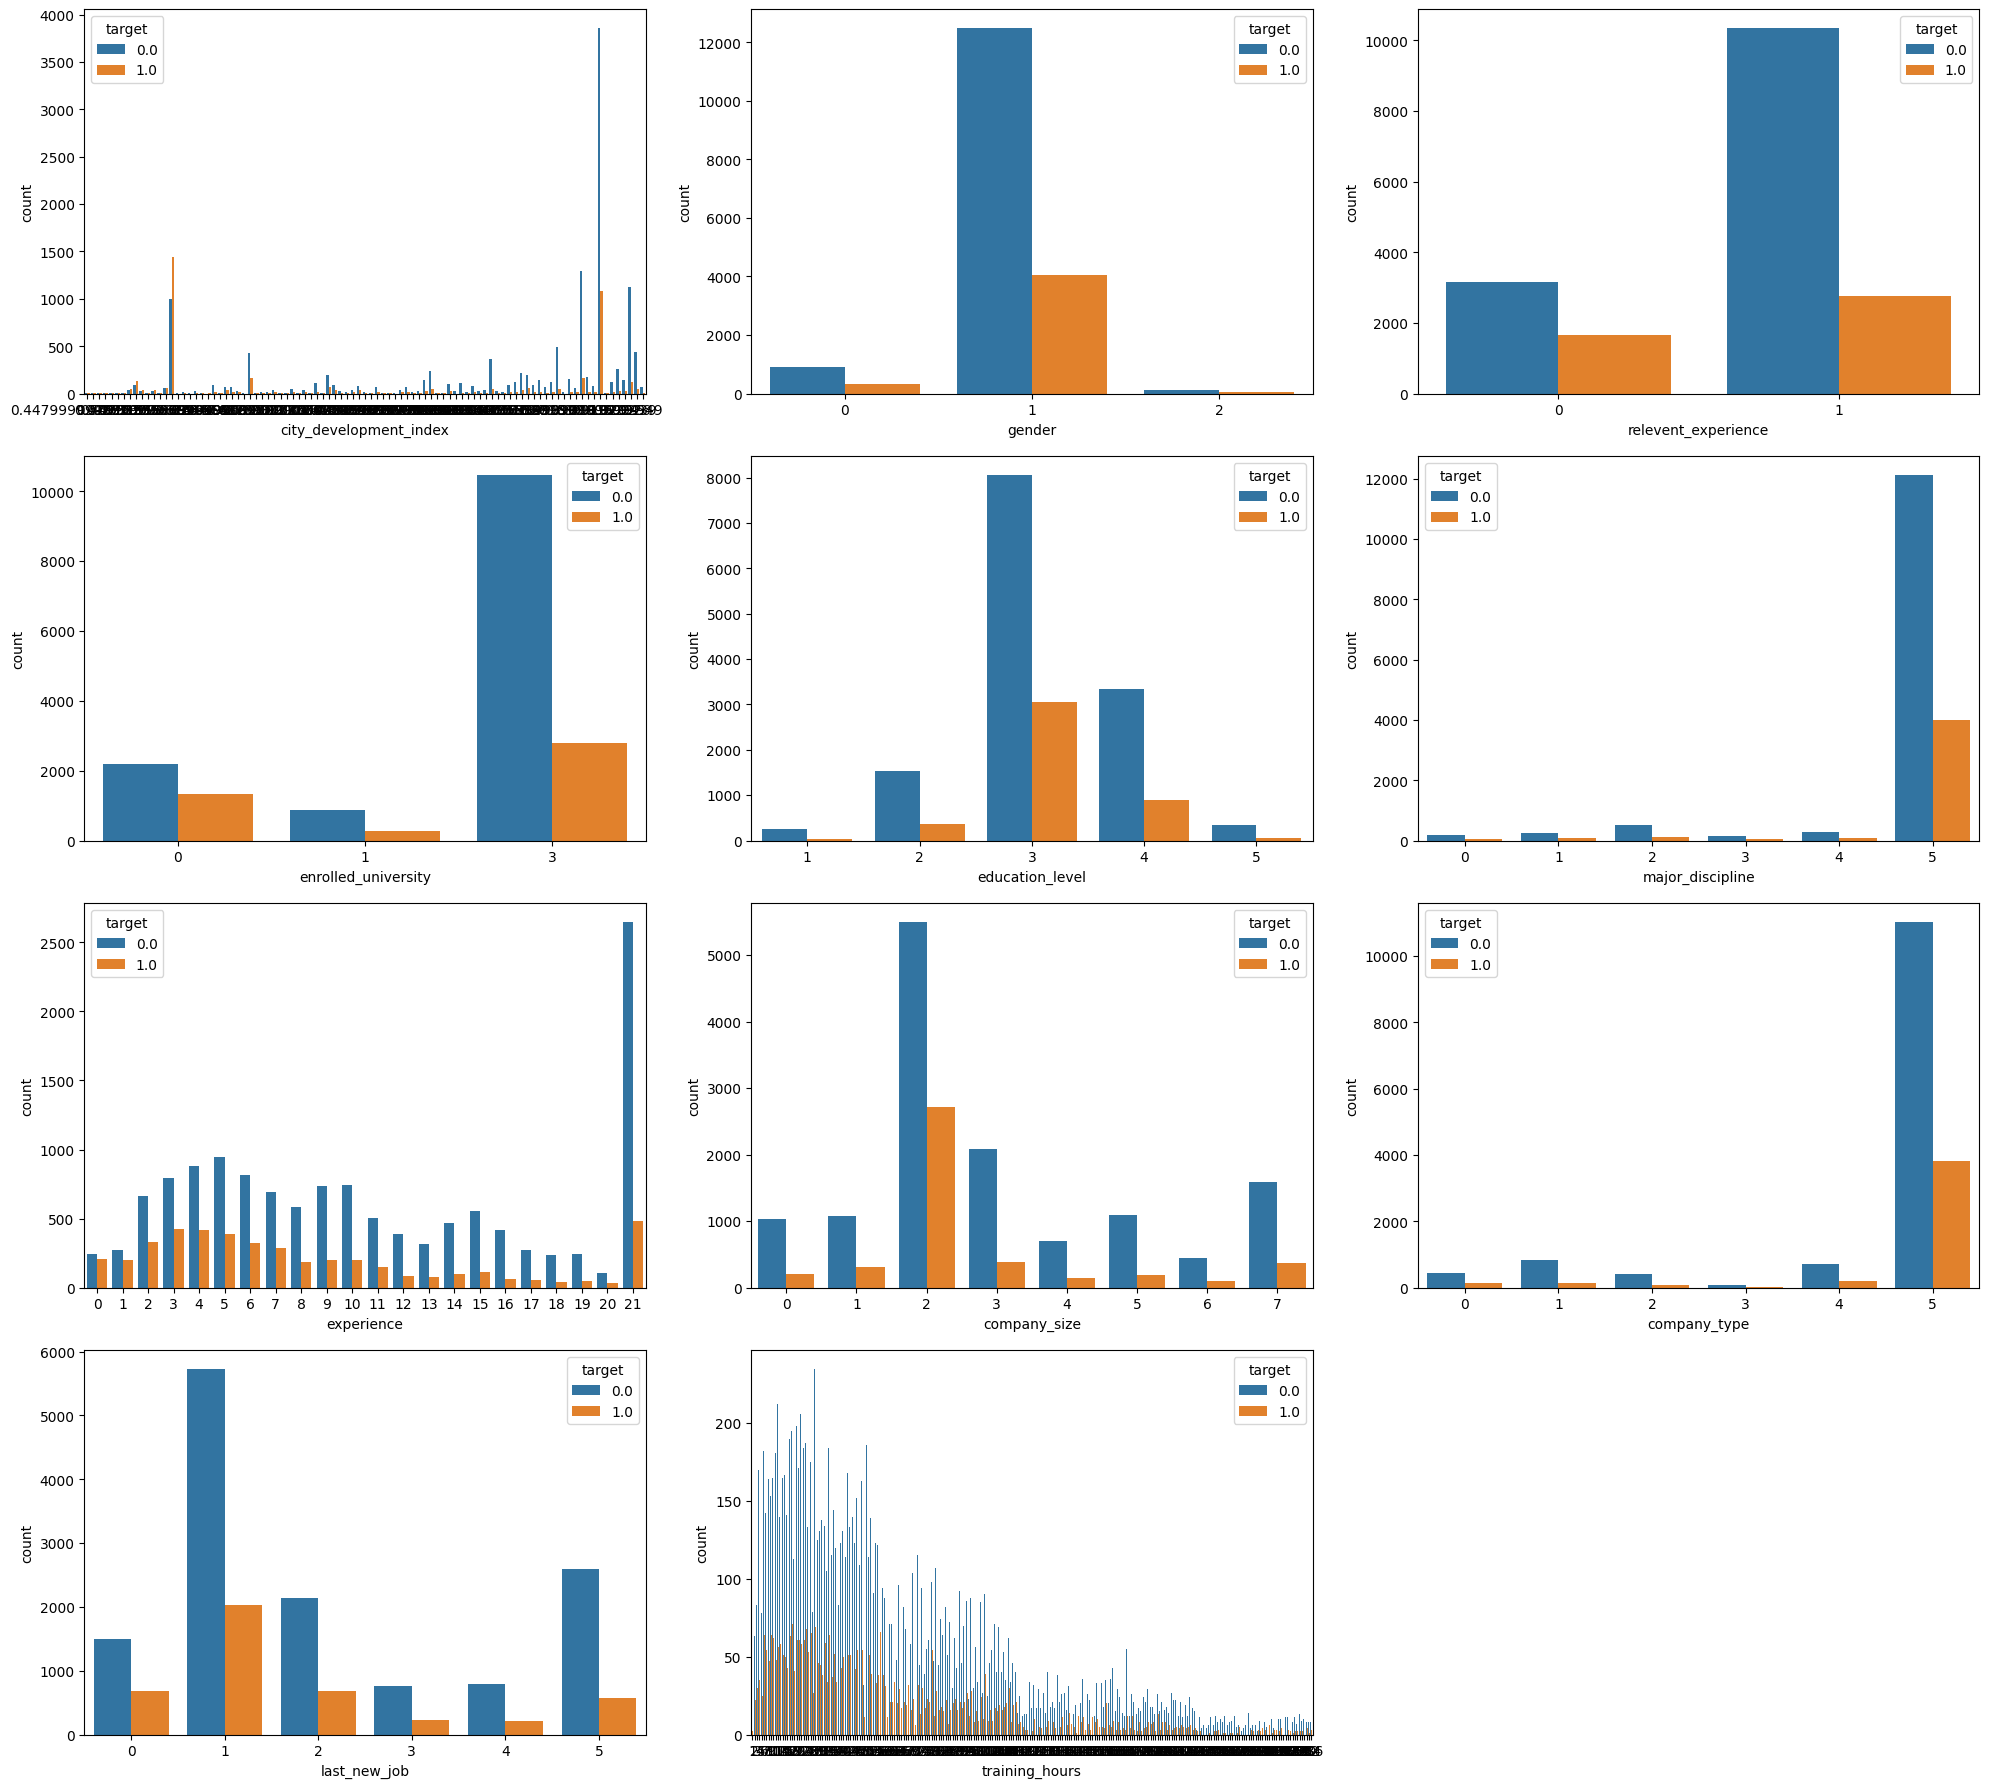

In [243]:
#use loop to plot visuals for all columns
cat_feat=df.drop(['city','target'],axis=1).columns

plt.figure(figsize=(20,18))
for i in range(len(cat_feat)):
    plt.subplot(4,3,i+1)
    sns.countplot(x=cat_feat[i],data=df,hue='target')
plt.tight_layout()
plt.show()

distribution


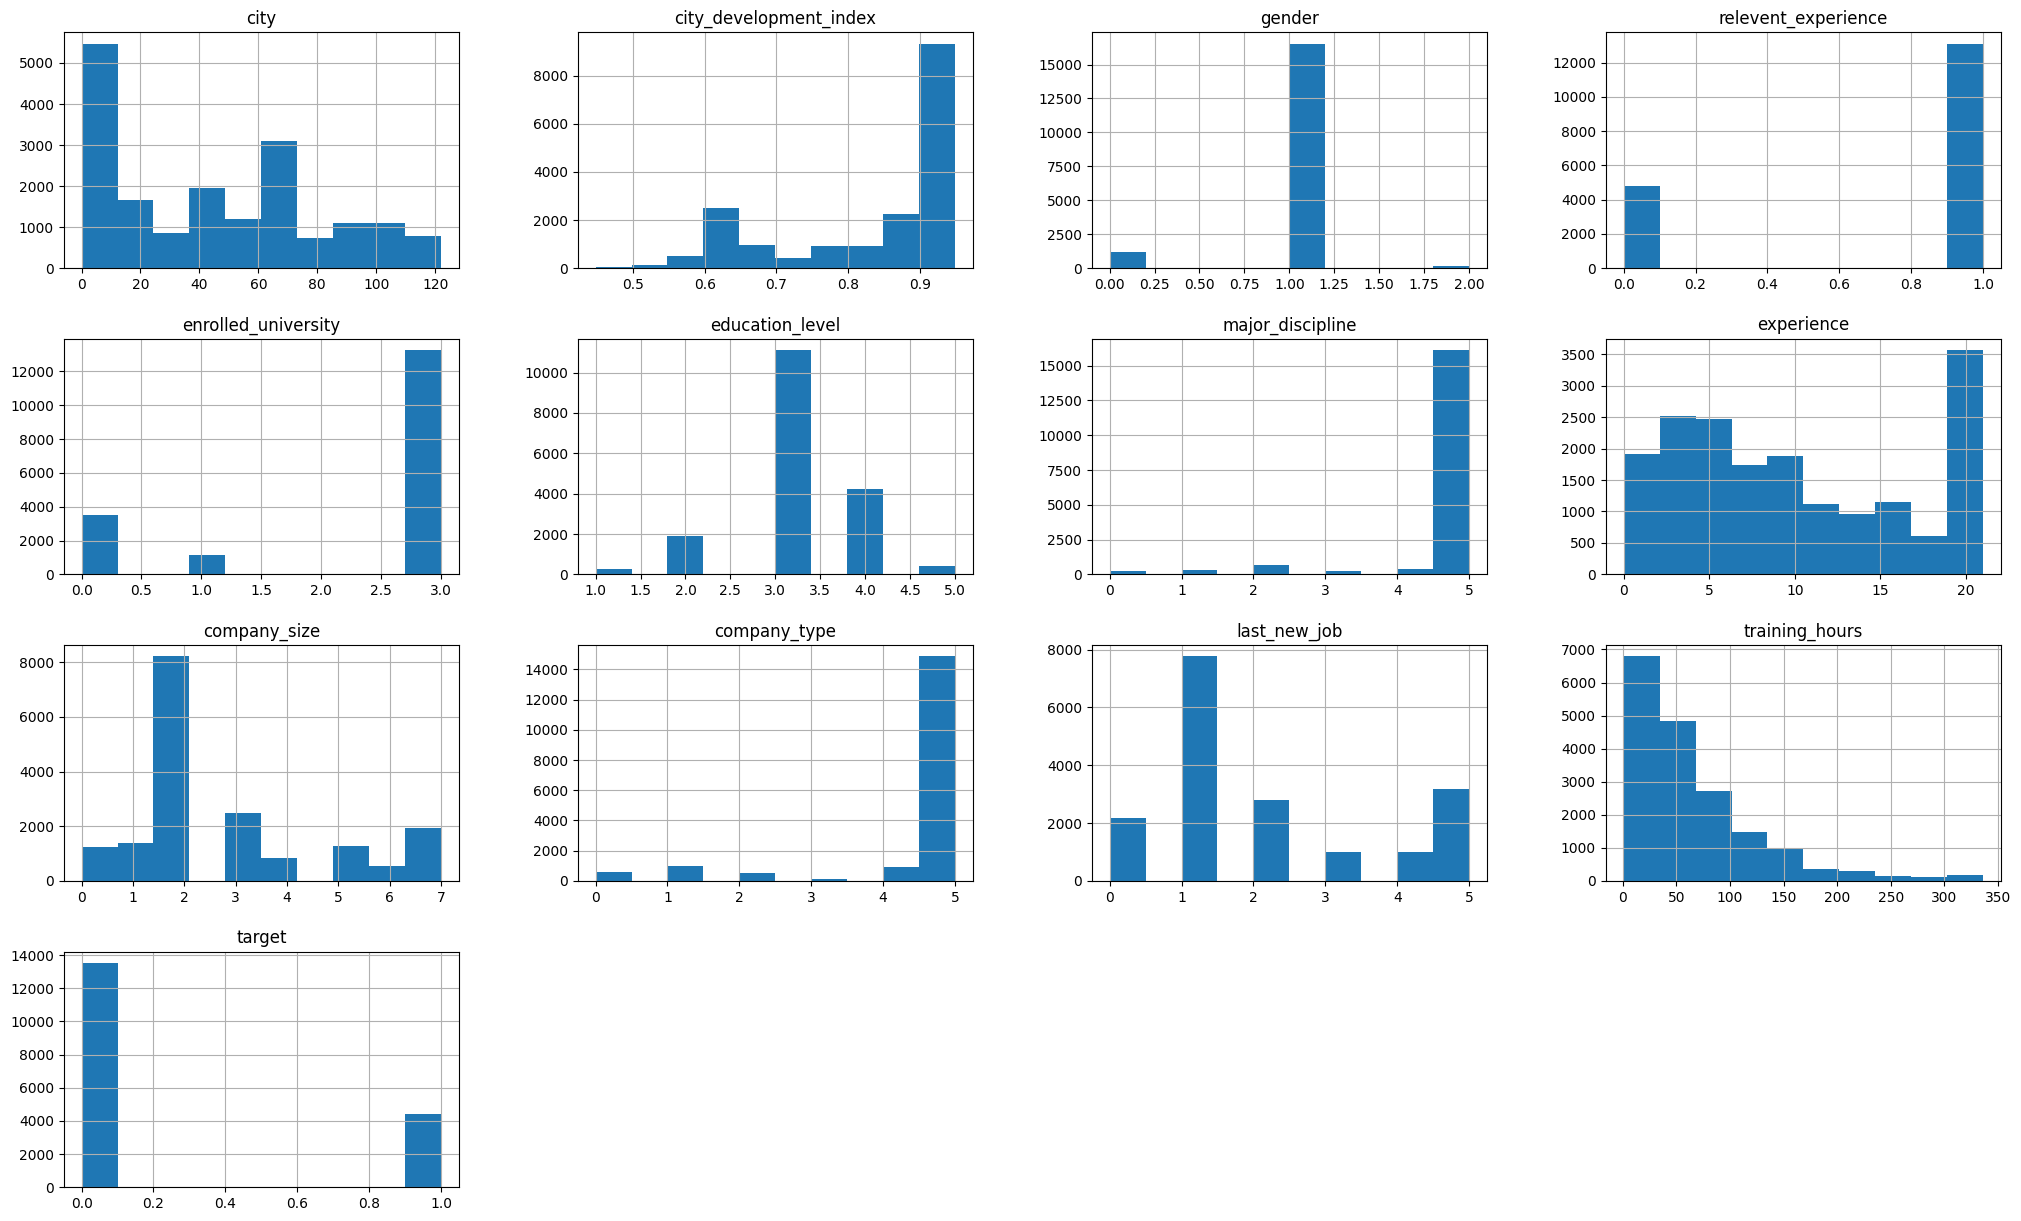

In [244]:
#plot distribution after scaling
df.hist(figsize = (25,15));

#handling outliers

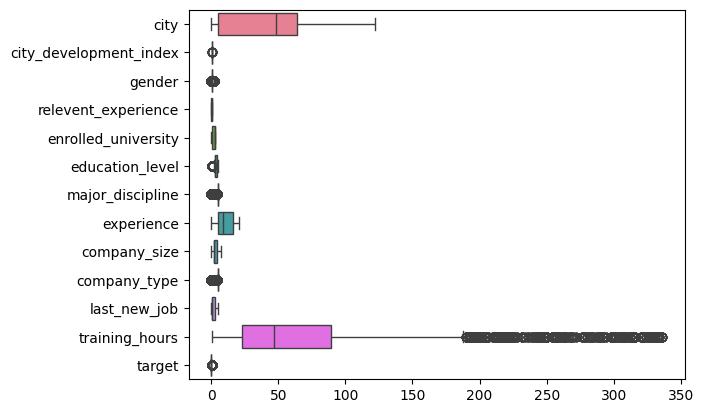

In [245]:
#observing presence of outliers
sns.boxplot(df, orient = 'h');

In [246]:
#remove outliers in training-hours column
low,high = df['training_hours'].quantile([0.1,0.9])
df = df[(df['training_hours'].between(low,high))]

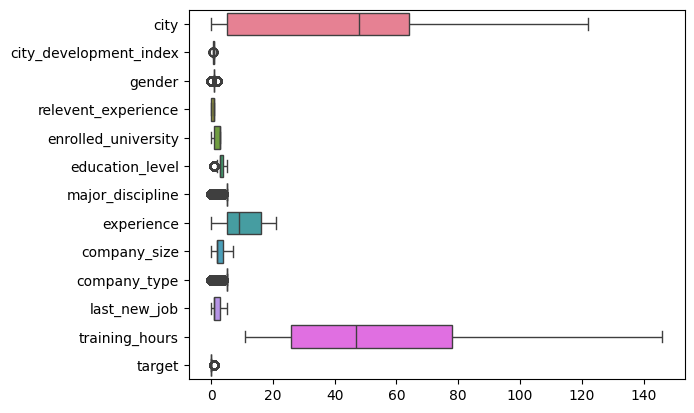

In [247]:
#observing the outliers after scaling
sns.boxplot(df, orient = 'h');

#Scaling

In [198]:
#scale using min-max scaling
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
normalized_df = scaler.fit_transform(df)

#convert back to df from array
df = pd.DataFrame(normalized_df, columns = df.columns)

## EDA after scaling

In [199]:
#Perform descriptive statistics to summarise the main characteristics of the dataset
df.describe().T

,count,mean,std,min,25%,50%,75%,max
city,14537.0,0.360223,0.290754,0.0,0.040984,0.393443,0.524590,1.0
city_development_index,14537.0,0.765776,0.244112,0.0,0.610778,0.922156,0.942116,1.0
gender,14537.0,0.470730,0.136992,0.0,0.500000,0.500000,0.500000,1.0
relevent_experience,14537.0,0.730618,0.443654,0.0,0.000000,1.000000,1.000000,1.0
enrolled_university,14537.0,0.763294,0.408121,0.0,0.333333,1.000000,1.000000,1.0
education_level,14537.0,0.536098,0.171492,0.0,0.500000,0.500000,0.750000,1.0
major_discipline,14537.0,0.940208,0.195834,0.0,1.000000,1.000000,1.000000,1.0
experience,14537.0,0.488212,0.321657,0.0,0.238095,0.428571,0.761905,1.0
company_size,14537.0,0.412268,0.275135,0.0,0.285714,0.285714,0.571429,1.0
company_type,14537.0,0.896155,0.260861,0.0,1.000000,1.000000,1.000000,1.0


obeserve correlation after scaling

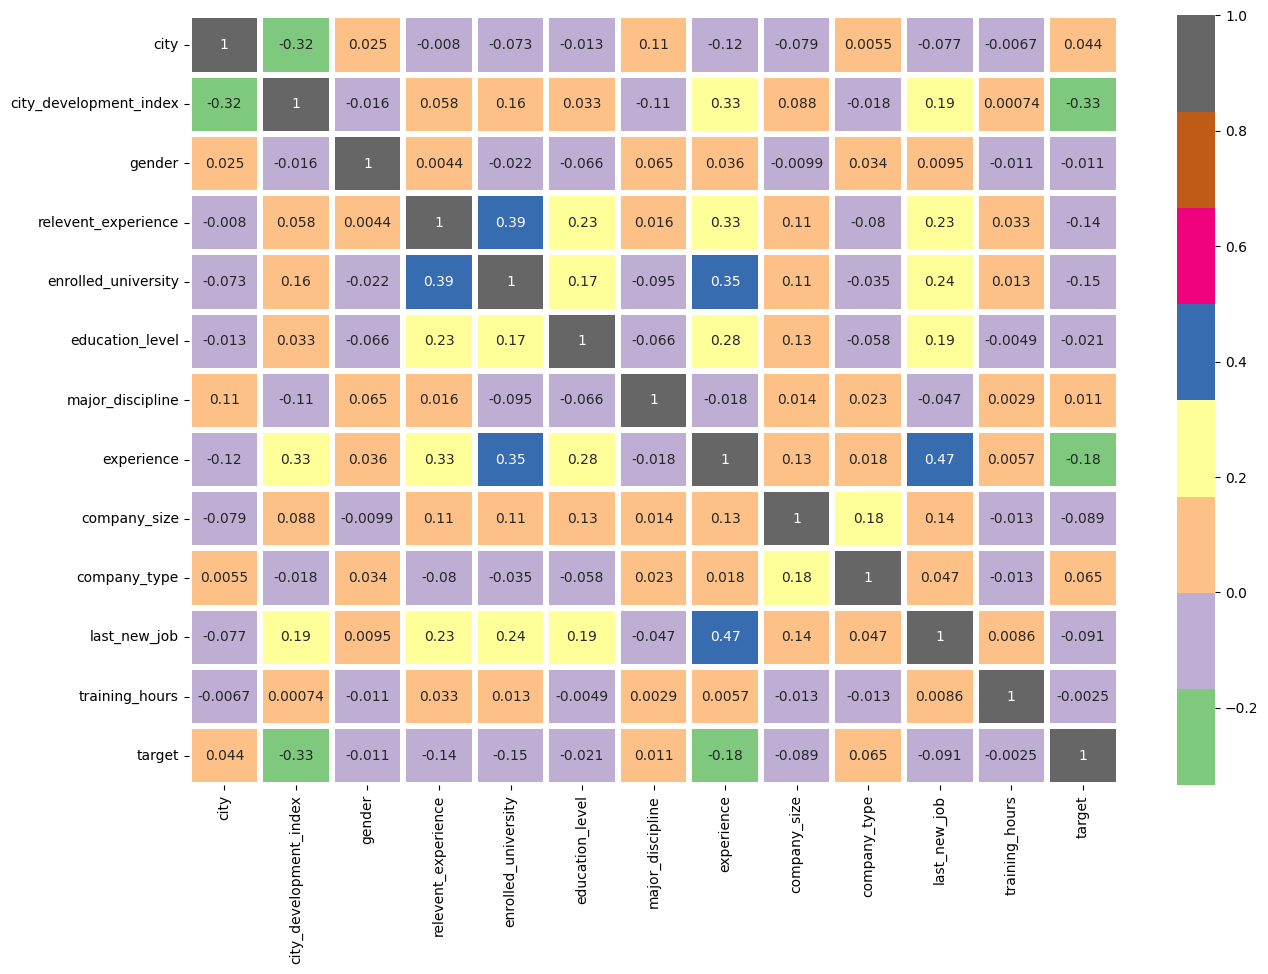

In [200]:
corr_matrix = df.corr() #calculate the correlation
#plot the correlation matrix
plt.figure(figsize = (15,10))
sns.heatmap(corr_matrix,annot= True,fmt='.2g',linewidths=4, cmap = 'Accent');

#Create a wrangle function


In [248]:
#form a wrangle function
def wrangle(filepath):

  #read the csv file into df
  df = pd.read_csv(filepath, index_col ='enrollee_id')


  #drop rows of columns with less than 10% null values
  df.dropna(subset =['enrolled_university','education_level','experience','last_new_job'], inplace = True)

  #fill columns with more than 10% null values with there mode

  df['gender'].fillna(df['gender'].mode()[0], inplace = True)
  df['major_discipline'].fillna(df['major_discipline'].mode()[0], inplace = True)
  df['company_size'].fillna(df['company_size'].mode()[0], inplace = True)
  df['company_type'].fillna(df['company_type'].mode()[0], inplace = True)

  #encode using label encoder
  lr = LabelEncoder()
  columns = ['city','gender','major_discipline','company_type']
  for col in columns:
    df[col] = lr.fit_transform(df[col])



#encode ordinal data with ordinal encoding
  df['relevent_experience'] = df['relevent_experience'].map({'Has relevent experience': 1,'No relevent experience': 0})
  df['enrolled_university'] = df['enrolled_university'].map({'Full time course': 0,'Part time course': 1,'no_enrollment': 3})
  df['education_level'] = df['education_level'].map({'Graduate': 3,'Masters': 4,'High School': 2,'Phd': 5,'Primary School': 1})
  df['company_size'] = df['company_size'].map({'50-99':2, '<10':0, '10000+':7, '5000-9999':6, '1000-4999':5, '10/49':1, '100-500':3,'500-999':4})

  df['experience'] = df['experience'].replace({'>20':21, '<1':0}).astype(int)
  df['last_new_job'] = df['last_new_job'].replace({'>4':5,'never':0}).astype(int)

  #encode using label encoder
  from sklearn.preprocessing import LabelEncoder
  le = LabelEncoder()
  df['city'] = le.fit_transform(df['city'])

  #remove outliers in training-hours column
  low = df['training_hours'].quantile(0.01)
  high = df['training_hours'].quantile(0.90)

  #scale using min-max scaling
  from sklearn.preprocessing import MinMaxScaler
  scaler = MinMaxScaler()
  # Create a new variable for the scaled data to prevent overwriting
  scaled_data = scaler.fit_transform(df)

  #convert back to df from array
  # Use the new variable and the original df's columns
  df = pd.DataFrame(scaled_data, columns = df.columns)

  return df

#Dataset Splitting

In [202]:
# Split data
X = df.drop('target', axis = 1) # features
y = df['target'] #target column

# Apply SMOTE to balance the training set
smote = SMOTE(random_state=1)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2, random_state = 1)

# Apply SMOTE only to the training data
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)




#Model development

##LogisticRegression

In [134]:
#build logistic regression model
LR = LogisticRegression(random_state = 1)

#fit the model
LR.fit(X_train_smote, y_train_smote)

#make prediction
y_pred = LR.predict(X_test)

#evaluate the model
PS = precision_score(y_pred, y_test, average = 'binary')
RS = recall_score(y_pred, y_test, average = 'binary')
AS = accuracy_score(y_pred, y_test)
FS = f1_score(y_pred, y_test, average = 'binary')

#form dict
metrics ={
    'Model' : ['Logistic Regression'],
    'Accuracy':[AS],
    'Precision':[PS],
    'Recall':[RS],
    'F1 Score':[FS]
}


#form a dataframe and output
LR_metrics = pd.DataFrame(metrics)

print(LR_metrics)

                 Model  Accuracy  Precision    Recall  F1 Score
0  Logistic Regression  0.708735   0.658537  0.429775  0.520113


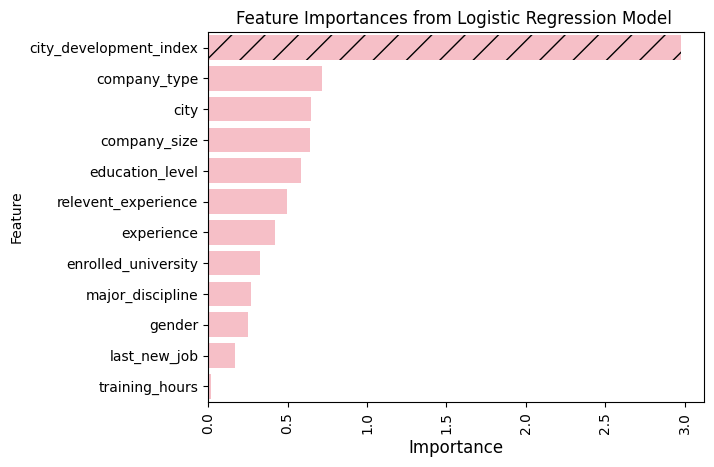

In [159]:
LR.fit(X,y)
coefficients = LR.coef_[0]
#Create a DataFrame with the feature importances
feature_importances_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': coefficients
})

#sort the df in terms of the importance
feature_importances_df['Importance'] = feature_importances_df['Importance'].abs()
feature_importances_df = feature_importances_df.sort_values(by='Importance', ascending=False)

#plot a bar plot
bars=sns.barplot(x='Importance',y='Feature',data=feature_importances_df,color='lightpink')
bars.patches[0].set_hatch('/')
plt.ylabel('Feature')
plt.xlabel('Importance',fontsize=12)
plt.title('Feature Importances from Logistic Regression Model ')
plt.xticks(rotation=90)
plt.show()

##Random Forest

In [136]:
#instatiate Random Forest
RF = RandomForestClassifier(random_state = 100)

#fit the model
RF.fit(X_train_smote, y_train_smote)

#make predictions
y_pred = RF.predict(X_test)

#evaluate the model
PS = precision_score(y_pred, y_test)
RS = recall_score(y_pred, y_test)
AS = accuracy_score(y_pred, y_test)
FS = f1_score(y_pred, y_test)

#form dict
metrics ={
    'Model' : ['Random Forest'],
    'Accuracy':[AS],
    'Precision':[PS],
    'Recall':[RS],
    'F1 Score':[FS]
}

#form a dataframe and output
RF_metrics = pd.DataFrame(metrics)

print(RF_metrics)


           Model  Accuracy  Precision    Recall  F1 Score
0  Random Forest  0.763411   0.490674  0.506667  0.498542


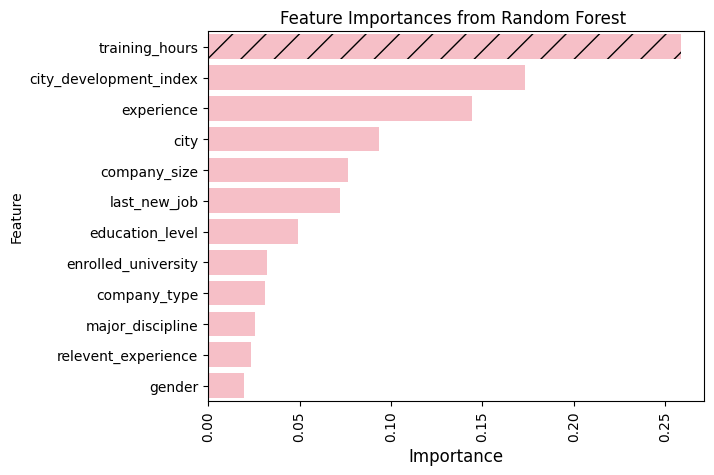

In [161]:
RF.fit(X,y)
coefficients = RF.feature_importances_
#Create a DataFrame with the feature importances
feature_importances_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': coefficients
})

#sort the df in terms of the importance
feature_importances_df = feature_importances_df.sort_values(by='Importance', ascending=False)

#plot a bar plot
bars=sns.barplot(x='Importance',y='Feature',data=feature_importances_df,color='lightpink')
bars.patches[0].set_hatch('/')
plt.ylabel('Feature')
plt.xlabel('Importance',fontsize=12)
plt.title('Feature Importances from Random Forest ')
plt.xticks(rotation=90)
plt.show()


##Gradient Boosting


In [138]:
# instatiate the model
from sklearn.ensemble import GradientBoostingClassifier
GB = GradientBoostingClassifier(random_state = 100)

#fit the model
GB.fit(X_train_smote, y_train_smote)

#make predictions
y_pred = GB.predict(X_test)


#evaluate the model
PS = precision_score(y_test, y_pred)
RS = recall_score(y_test, y_pred)
AS = accuracy_score(y_test, y_pred)
FS = f1_score(y_test, y_pred)

#form dict
metrics ={
    'Model' : ['Gradient Boosting'],
    'Accuracy':[AS],
    'Precision':[PS],
    'Recall':[RS],
    'F1 Score':[FS]
}

#form a dataframe and output
GB_metrics = pd.DataFrame(metrics)

print(GB_metrics)

               Model  Accuracy  Precision    Recall  F1 Score
0  Gradient Boosting  0.768226   0.512994  0.651363  0.573957


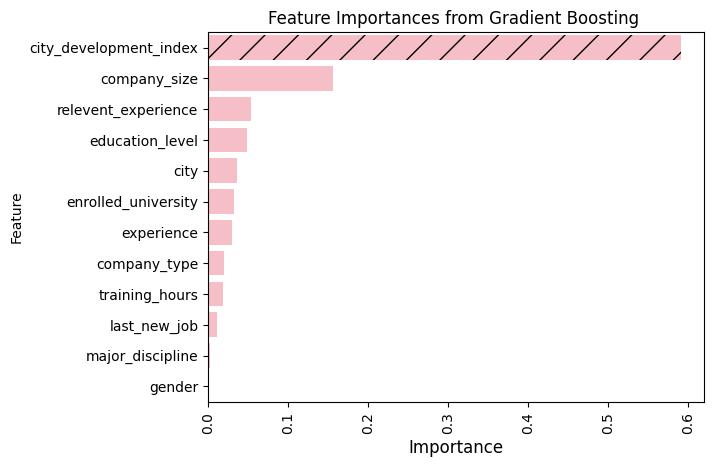

In [160]:
GB.fit(X,y)
coefficients = GB.feature_importances_
#Create a DataFrame with the feature importances
feature_importances_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': coefficients
})

#sort the df in terms of the importance
feature_importances_df = feature_importances_df.sort_values(by='Importance', ascending=False)

#plot a bar plot
bars=sns.barplot(x='Importance',y='Feature',data=feature_importances_df,color='lightpink')
bars.patches[0].set_hatch('/')
plt.ylabel('Feature')
plt.xlabel('Importance',fontsize=12)
plt.title('Feature Importances from Gradient Boosting ')
plt.xticks(rotation=90)
plt.show()

#Model comparison

In [143]:
#form a df for the metrics
metrics_df = pd.concat([LR_metrics,RF_metrics,GB_metrics], axis = 0)
metrics_df = metrics_df1.reset_index(drop=True) #DROP the indexes
metrics_df


,Model,Accuracy,Precision,Recall,F1 Score
0,Logistic Regression,0.708735,0.658537,0.429775,0.520113
1,Random Forest,0.763411,0.490674,0.506667,0.498542
2,Gradient Boosting,0.768226,0.512994,0.651363,0.573957


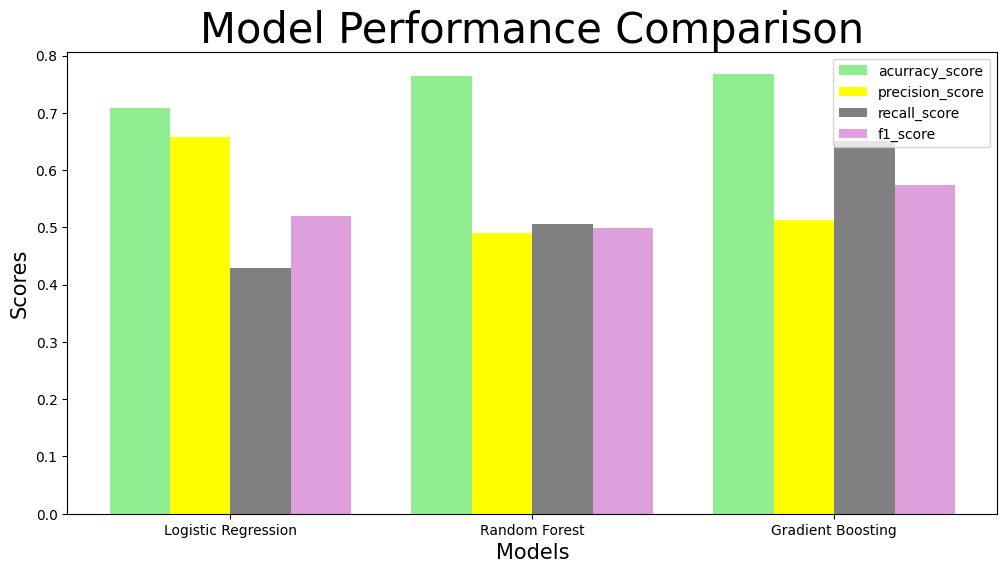

In [211]:
plt.figure(figsize=(12, 6))
bar_width = 0.2
xpos=np.arange(len(metrics_df['Model']))
bars1=plt.bar(xpos - 0.3,metrics_df['Accuracy'] , width=bar_width, label="acurracy_score",color='lightgreen')
bars2=plt.bar(xpos - 0.1,metrics_df['Precision'], width=bar_width, label="precision_score",color='yellow')
bars3=bars=plt.bar(xpos + 0.1, metrics_df['Recall'], width=bar_width, label="recall_score",color='gray')
bars4=plt.bar(xpos + 0.3,metrics_df['F1 Score'], width=bar_width, label="f1_score",color='plum')

plt.xticks(xpos, metrics_df['Model'])
plt.legend()
plt.xlabel("Models",fontsize=15)
plt.ylabel("Scores",fontsize=15)
plt.title("Model Performance Comparison",fontsize=30)
plt.show()

# Prediction

In [256]:
#wrangle the test data
filepath = '/content/drive/MyDrive/promo/aug_test(1).csv'

test_df = wrangle(filepath)
type(test_df)

NoneType